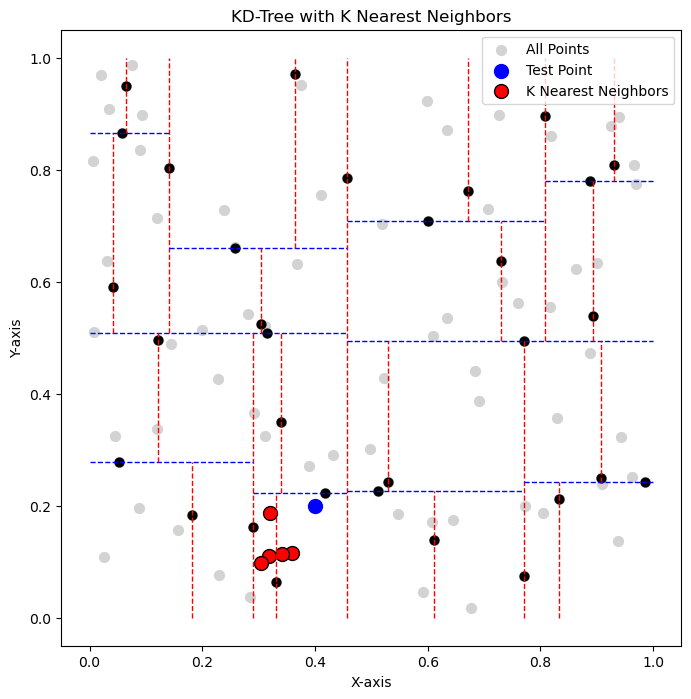

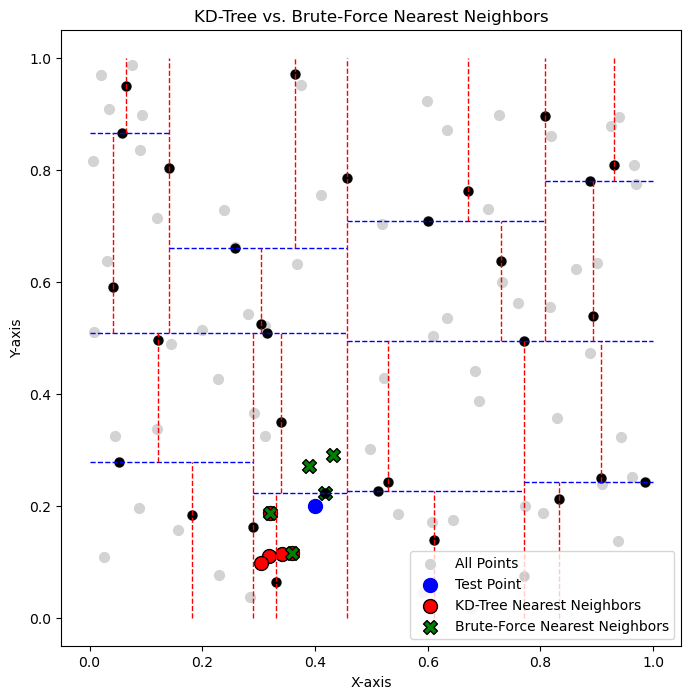

In [56]:
import numpy as np
import matplotlib.pyplot as plt

# KD-Tree Node definition (stores all points in the region)
class KDTreeNode:
    def __init__(self, point, points_in_region=None, left=None, right=None, axis=None):
        self.point = point
        self.points_in_region = points_in_region  # All points in the region/subtree
        self.left = left
        self.right = right
        self.axis = axis

# Function to build KD-Tree
def build_kd_tree(points, depth=0, max_depth=5):
    if not len(points) or (max_depth is not None and depth >= max_depth):
        return None

    k = points.shape[1]  # Dimensionality
    axis = depth % k     # Splitting axis based on depth
    sorted_points = points[np.argsort(points[:, axis])]  # Sort points along the axis
    median_idx = len(sorted_points) // 2  # Find the median index

    return KDTreeNode(
        point=sorted_points[median_idx],
        points_in_region=sorted_points,  # Store all points in this region
        left=build_kd_tree(sorted_points[:median_idx], depth + 1, max_depth),
        right=build_kd_tree(sorted_points[median_idx + 1:], depth + 1, max_depth),
        axis=axis
    )

# Function to find the region node for a test point
def find_region_node(root, test_point, depth=0):
    if root is None or (root.left is None and root.right is None):
        return root
    axis = depth % len(test_point)
    if test_point[axis] < root.point[axis]:
        return find_region_node(root.left, test_point, depth + 1) or root
    else:
        return find_region_node(root.right, test_point, depth + 1) or root

# Plot KD-Tree and nearest neighbors
def plot_kd_tree_and_neighbors(points, test_point, nearest_points, kd_tree_root):
    fig, ax = plt.subplots(figsize=(8, 8))

    # Plot all points
    ax.scatter(points[:, 0], points[:, 1], c='lightgray', label="All Points", s=50)
    
    # Highlight the test point
    ax.scatter(test_point[0], test_point[1], c='blue', label="Test Point", s=100)
    
    # Highlight the k-nearest neighbors
    nearest_x = [p[0] for p in nearest_points]
    nearest_y = [p[1] for p in nearest_points]
    ax.scatter(nearest_x, nearest_y, c='red', s=100, edgecolors='black', label="K Nearest Neighbors")
    
    # Recursively plot KD-Tree partitions
    plot_kd_tree(kd_tree_root, bounds=(0, 1, 0, 1), ax=ax)
    
    # Add labels and legend
    ax.set_title("KD-Tree with K Nearest Neighbors")
    ax.set_xlabel("X-axis")
    ax.set_ylabel("Y-axis")
    ax.legend()
    plt.show()

# Function to recursively plot KD-Tree partitions
def plot_kd_tree(node, bounds, depth=0, ax=None):
    if node is None:
        return
    k = len(node.point)
    axis = depth % k
    xmin, xmax, ymin, ymax = bounds
    if axis == 0:  # Vertical split
        ax.plot([node.point[0], node.point[0]], [ymin, ymax], 'r--', lw=1)
        plot_kd_tree(node.left, (xmin, node.point[0], ymin, ymax), depth + 1, ax)
        plot_kd_tree(node.right, (node.point[0], xmax, ymin, ymax), depth + 1, ax)
    else:  # Horizontal split
        ax.plot([xmin, xmax], [node.point[1], node.point[1]], 'b--', lw=1)
        plot_kd_tree(node.left, (xmin, xmax, ymin, node.point[1]), depth + 1, ax)
        plot_kd_tree(node.right, (xmin, xmax, node.point[1], ymax), depth + 1, ax)
    ax.scatter(*node.point, c='black', s=40)

# Generate random points
np.random.seed(42)
points = np.random.rand(100, 2)  # 100 points in 2D
test_point = np.array([0.4, 0.2])  # Specific test point
k = 5  # Number of nearest neighbors

# Build the KD-Tree
kd_tree_root = build_kd_tree(points)

# Find the region where the test point lies
region_node = find_region_node(kd_tree_root, test_point)

# Calculate distances and find k-nearest neighbors within the region
distances = [np.linalg.norm(p - test_point) for p in region_node.points_in_region]
sorted_indices = np.argsort(distances)[:k]
nearest_points = region_node.points_in_region[sorted_indices]

# Plot the KD-Tree and k-nearest neighbors
plot_kd_tree_and_neighbors(points, test_point, nearest_points, kd_tree_root)

from sklearn.neighbors import NearestNeighbors

# Brute-force k-nearest neighbors using sklearn
nbrs = NearestNeighbors(n_neighbors=k, algorithm='brute').fit(points)
distances_brute, indices_brute = nbrs.kneighbors([test_point])
brute_force_points = points[indices_brute[0]]

# Updated plot function to include brute-force neighbors
def plot_kd_tree_with_brute_force(points, test_point, nearest_points_kd, nearest_points_brute, kd_tree_root):
    fig, ax = plt.subplots(figsize=(8, 8))

    # Plot all points
    ax.scatter(points[:, 0], points[:, 1], c='lightgray', label="All Points", s=50)
    
    # Highlight the test point
    ax.scatter(test_point[0], test_point[1], c='blue', label="Test Point", s=100)
    
    # Highlight k-nearest neighbors found by KD-Tree
    kd_x = [p[0] for p in nearest_points_kd]
    kd_y = [p[1] for p in nearest_points_kd]
    ax.scatter(kd_x, kd_y, c='red', s=100, edgecolors='black', label="KD-Tree Nearest Neighbors")
    
    # Highlight k-nearest neighbors found by brute force
    brute_x = [p[0] for p in nearest_points_brute]
    brute_y = [p[1] for p in nearest_points_brute]
    ax.scatter(brute_x, brute_y, c='green', s=100, edgecolors='black', marker='X', label="Brute-Force Nearest Neighbors")
    
    # Recursively plot KD-Tree partitions
    plot_kd_tree(kd_tree_root, bounds=(0, 1, 0, 1), ax=ax)
    
    # Add labels and legend
    ax.set_title("KD-Tree vs. Brute-Force Nearest Neighbors")
    ax.set_xlabel("X-axis")
    ax.set_ylabel("Y-axis")
    ax.legend()
    plt.show()

# Plot KD-Tree and brute-force neighbors on the same graph
plot_kd_tree_with_brute_force(points, test_point, nearest_points, brute_force_points, kd_tree_root)

